# Getting sentiment from ChatGPT

In [2]:
import numpy as np
import pandas as pd
import requests
import re
import sqlite3
import time
import openai
import redis
from matplotlib import pyplot as plt
import asyncio
from datetime import datetime

In [3]:
# r = redis.Redis("localhost", 5211, decode_responses=True)
db = sqlite3.connect("scraping.db")

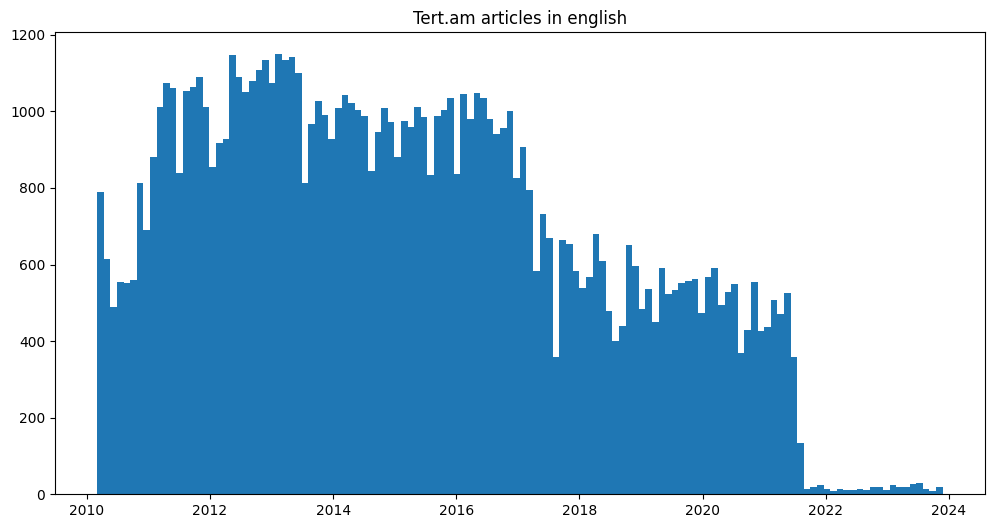

In [6]:
cur = db.execute("select time from article")
db.commit()

fig, ax= plt.subplots(figsize=(12, 6))
times = pd.Series([i[0] for i in cur])
times = pd.to_datetime(times)
times.hist(bins=128)
ax.set_title("Tert.am articles in english")
plt.grid(False)
plt.savefig("TertamEnglishArticleHist.png")
plt.show()

In [ ]:
cur = db.execute("select count(*) from article where (headline like '%Russia%' or content like '%United States%') and feedback is null")
db.commit()

list(cur)

In [ ]:
messages = [{
    "role": "system", 
    "content": "Read the article, list named entities discussed in it, choose a sentiment between positive, neutral, and negative for each listed entity separately. Provide your answer in a json format with keys 'name', 'sentiment', 'explanation'."
}]

with open("../key.txt", "r") as f:
    client = openai.AsyncOpenAI(
        api_key=f.read(),
    )

limit = False

while True:
    cur = db.execute("select id, headline, content from article where (headline like '%Russia%' or content like '%United States%') and feedback is null order by random() limit 512")
    db.commit()

    l = list(cur)

    if len(l) == 0:
        break

    async def get_sentiment(row):
        chat = await client.chat.completions.create( 
            model="gpt-3.5-turbo-1106", 
            response_format={ "type": "json_object" },
            messages=messages + [{"role": "user", "content": "Title: " + row[1] + "\nContent: " + row[2]}] 
        )
        reply = chat.choices[0].message.content

        return row[0], reply

    async def multiple_sentiments(rows):
        tasks = [get_sentiment(row) for row in rows]
        res = await asyncio.gather(*tasks, return_exceptions=True)
        return res

    res = await multiple_sentiments(l)
    print(res)
    for r in res:
        try:
            db.execute(f'update article set feedback = ? where id = ?', (r[1], r[0]))
        except TypeError as e:
            limit = True
            db.commit()
            cur = db.execute("select count(*) from article where feedback is not null")
            db.commit()
            print(f"Got {list(cur)[0][0]} feedbacks!", end="\r")
    db.commit()
    if limit:
        limit = False
        time.sleep(61)

In [1]:
cur = db.execute("select count(*) from article where feedback is not null")
db.commit()

(l := list(cur))

NameError: name 'db' is not defined

In [ ]:
cur = db.execute(f'select count(*) from article where content like "%United States%"')
db.commit()

(l := list(cur))

In [ ]:
cur = db.execute(f'select count(*) from article where feedback like "%Russia%"')
db.commit()

(l := list(cur))

In [ ]:
cur = db.execute(f'select count(*) from article where headline like "%Russia%"')
db.commit()

(l := list(cur))